# Machine Learning Portfolio 2

|Name|Github|Kaggle|
|----|------|------|
|Henry Lau|HenryLau08|Henry Lau|
|Mohamed Belaachir|mobelaachir|Mo Belaachir|
|Jayden Debi-Tewari|Jaydendt1|jaydendt123|
|Quincy Soerohardjo|quincysoerohardjo2002|Quincy Soerohardjo|
|Mattias Aareleid|mattyonaize|Mattias Aareleid|

## Table of Contents
- [Data Overview](#data-overview)
- [Exploratory Data Analysis](#exploratory-data-analysis)
- [Modeling](#modeling)

- [Results](#results)
- [Conclusion & Advice](#conclusion--advice)
- [Sources](#sources)

In [ ]:
# Libraries

import os
import warnings
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.fft import fft, ifft
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor
from xgboost import XGBRegressor

pd.set_option('display.max_columns', None)

## Data Overview

Wij hebben de kolom date_hour omgezet naar een datetime-formaat om tijdsreeksanalyses mogelijk te maken. Wanneer date_hour als een datetime-object is opgeslagen, kunnen we eenvoudig tijdsgebonden analyses uitvoeren.

In [ ]:
train = pd.read_csv('train.csv', parse_dates=['date_hour'], index_col='date_hour')
test = pd.read_csv('test.csv', parse_dates=['date_hour'], index_col='date_hour')
sample_submission = pd.read_csv('sample_submission.csv')

In [ ]:
# Train and Test data
display(train.head(10), test.head(10))

,holiday,weathersit,temp,atemp,hum,windspeed,cnt
date_hour,,,,,,,
2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0000,16
2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0000,40
2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0000,32
2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0000,13
2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0000,1
2011-01-01 05:00:00,0,2,0.24,0.2576,0.75,0.0896,1
2011-01-01 06:00:00,0,1,0.22,0.2727,0.80,0.0000,2
2011-01-01 07:00:00,0,1,0.20,0.2576,0.86,0.0000,3
2011-01-01 08:00:00,0,1,0.24,0.2879,0.75,0.0000,8


,holiday,weathersit,temp,atemp,hum,windspeed
date_hour,,,,,,
2012-12-01 00:00:00,0,1,0.26,0.3030,0.81,0.0000
2012-12-01 01:00:00,0,1,0.26,0.3030,0.81,0.0000
2012-12-01 02:00:00,0,2,0.26,0.3030,0.81,0.0000
2012-12-01 03:00:00,0,2,0.26,0.2727,0.81,0.1343
2012-12-01 04:00:00,0,1,0.26,0.2879,0.81,0.0896
2012-12-01 05:00:00,0,1,0.24,0.2576,0.87,0.0896
2012-12-01 06:00:00,0,1,0.24,0.2424,0.87,0.1343
2012-12-01 07:00:00,0,2,0.24,0.2424,0.87,0.1343
2012-12-01 08:00:00,0,2,0.24,0.2424,0.87,0.1343


In [ ]:
# Sample submission for kaggle
display(sample_submission.head(10))

,date_hour,cnt
0,2012-12-01 00:00:00,784
1,2012-12-01 01:00:00,80
2,2012-12-01 02:00:00,605
3,2012-12-01 03:00:00,604
4,2012-12-01 04:00:00,544
5,2012-12-01 05:00:00,100
6,2012-12-01 06:00:00,344
7,2012-12-01 07:00:00,18
8,2012-12-01 08:00:00,57
9,2012-12-01 09:00:00,603


## Exploratory Data Analysis

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16637 entries, 2011-01-01 00:00:00 to 2012-11-30 23:00:00
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   holiday     16637 non-null  int64  
 1   weathersit  16637 non-null  int64  
 2   temp        16637 non-null  float64
 3   atemp       16637 non-null  float64
 4   hum         16637 non-null  float64
 5   windspeed   16637 non-null  float64
 6   cnt         16637 non-null  int64  
dtypes: float64(4), int64(3)
memory usage: 1.0 MB


#### Data Types:  

Er zijn verschillende data types aanwezig:
- **datetime**: date_hour
- **Integer**: holiday, weathersit en cnt
- **Float**: temp, atemp, hum en windspeed

In [ ]:
display(train.describe())

,holiday,weathersit,temp,atemp,hum,windspeed,cnt
count,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000
mean,0.028671,1.415580,0.504745,0.482608,0.624756,0.190310,190.477009
std,0.166885,0.637298,0.192369,0.171557,0.193227,0.121915,182.026755
min,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,41.000000
50%,0.000000,1.000000,0.520000,0.500000,0.620000,0.194000,143.000000
75%,0.000000,2.000000,0.660000,0.621200,0.780000,0.253700,282.000000
max,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000


#### Controle op Ontbrekende Waarden

In [ ]:
print(train.isnull().sum())

holiday       0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64


Alle kolommen in deze dataset hebben geen ontbrekende waarden. Dit betekent dat er geen ontbrekende data hoeft te worden aangevuld of verwijderd, wat de analyse eenvoudiger maakt.

#### Vorm van de gegevens

In [ ]:
print(train.shape)

(16637, 7)


De dataset bevat 8 kolommen (variabelen) en 16.637 rijen.

#### Kolommen beschrijven:  
- **date_hour**: Datum en tijdstip.
- **holiday**: Geeft aan of de datum een feestdag is (0 = geen feestdag, 1 = feestdag).
- **weathersit**: De beschrijving van de weersomstandigheden op een schaal van 1 tot 4, waarbij 1 goed weer is en 4 heel slecht weer.
- **temp**: Genormaliseerd temperatuur
- **atemp**: Genormaliseerd gevoelstemperatuur
- **hum**: Genormaliseerd luchtvochtigheid
- **windspeed**: Genormaliseerd windsnelheid
- **cnt**: Aantal verhuurd

#### Het meetniveau voor elke kolom:  
- **date_hour**: Interval
- **holiday**: Nominaal (binaire categorische variabele: 0 = geen feestdag, 1 = feestdag).
- **weathersit**: Ordinaal (categorieën hebben een volgorde).
- **temp**: Interval (continue variabele).
- **atemp**: Interval (continue variabele).
- **hum**: Interval (continue variabele).
- **windspeed**: Interval (continue variabele).
- **cnt**: Ratio

In [ ]:
def resample_datetime(df):
    data = df.copy()
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['week_of_year'] = data.index.isocalendar().week
    data['day_of_year'] = data.index.day_of_year
    data['day_of_month'] = data.index.day
    data['day_of_week'] = data.index.weekday
    data['hour'] = data.index.hour
    return data

In [ ]:
data = resample_datetime(train)
display(data)

,holiday,weathersit,temp,atemp,hum,windspeed,cnt,year,month,week_of_year,day_of_year,day_of_month,day_of_week,hour
date_hour,,,,,,,,,,,,,,
2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0000,16,2011,1,52,1,1,5,0
2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0000,40,2011,1,52,1,1,5,1
2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0000,32,2011,1,52,1,1,5,2
2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0000,13,2011,1,52,1,1,5,3
2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0000,1,2011,1,52,1,1,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-11-30 19:00:00,0,1,0.32,0.3485,0.66,0.0000,377,2012,11,48,335,30,4,19
2012-11-30 20:00:00,0,1,0.32,0.3485,0.66,0.0000,245,2012,11,48,335,30,4,20
2012-11-30 21:00:00,0,1,0.30,0.3182,0.75,0.0896,183,2012,11,48,335,30,4,21


### Visualiseren

In [ ]:
class DataVisualizer:
    def __init__(self, dataframe):
        # Ensure the dataframe has a datetime index
        if not isinstance(dataframe.index, pd.DatetimeIndex):
            raise ValueError("The dataframe index must be a DatetimeIndex.")
        self.df = dataframe.copy()
        sns.set_style('darkgrid')

    def plot_time_series(self, value_col, year=None, title="Time Series Analysis", xlabel="Time", ylabel="Value"):
        """
        Plots a time series for a specific column, optionally filtered by year.
        
        Parameters:
            value_col (str): The column to plot.
            year (int, optional): The year to filter the data. If None, plots all years.
            title (str): The title of the plot.
            xlabel (str): The label for the x-axis.
            ylabel (str): The label for the y-axis.
        """
        data_to_plot = self.df
        if year is not None:
            data_to_plot = data_to_plot[data_to_plot.index.year == year]
            title += f" ({year})"
        
        plt.figure(figsize=(14, 6))
        plt.plot(data_to_plot.index, data_to_plot[value_col])
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()

    def plot_distributions(self, continuous_cols, bins=30):
        n_cols = 2
        n_rows = (len(continuous_cols) + 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 5))
        fig.suptitle("Distribution of Continuous Variables", fontsize=16)
        axes = axes.flatten()
        
        for i, col in enumerate(continuous_cols):
            sns.histplot(self.df[col], bins=bins, kde=True, ax=axes[i])
            axes[i].set_title(f"Distribution of '{col}'")
        
        for j in range(len(continuous_cols), len(axes)):  # Hide extra subplots
            fig.delaxes(axes[j])
            
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    def plot_categorical_counts(self, categorical_cols):
        n_cols = 2
        n_rows = (len(categorical_cols) + 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 5))
        fig.suptitle("Distribution of Categorical Variables", fontsize=16)
        axes = axes.flatten()
        
        for i, col in enumerate(categorical_cols):
            sns.countplot(x=self.df[col], ax=axes[i])
            axes[i].set_title(f"Distribution of '{col}'")
        
        for j in range(len(categorical_cols), len(axes)):  # Hide extra subplots
            fig.delaxes(axes[j])
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    def plot_boxplots(self, cols, title="Boxplots for Outliers"):
        fig, axes = plt.subplots(1, len(cols), figsize=(5 * len(cols), 6))
        fig.suptitle(title, fontsize=16)
        
        for i, col in enumerate(cols):
            sns.boxplot(y=self.df[col], ax=axes[i])
            axes[i].set_title(col)
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    def plot_time_components_vs_cnt(self, time_components, target_col='cnt', title="Time Components vs. Target"):
        n_cols = 2
        n_rows = (len(time_components) + 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 5))
        fig.suptitle(title, fontsize=16)
        axes = axes.flatten()
        
        for i, component in enumerate(time_components):
            sns.lineplot(x=component, y=target_col, data=self.df, ax=axes[i])
            axes[i].set_title(f"{component} vs. {target_col}")
        
        for j in range(len(time_components), len(axes)):  # Hide extra subplots
            fig.delaxes(axes[j])
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    def plot_boxplot(self, x_col, y_col, title=None, xlabel=None, ylabel=None):
        plt.figure(figsize=(8, 6))
        sns.boxplot(x=self.df[x_col], y=self.df[y_col])
        plt.title(title if title else f"Boxplot of '{y_col}' by '{x_col}'")
        plt.xlabel(xlabel if xlabel else x_col)
        plt.ylabel(ylabel if ylabel else y_col)
        plt.show()

    def plot_correlation_matrix(self, cols, title="Correlation Matrix"):
        plt.figure(figsize=(10, 8))
        correlation_matrix = self.df[cols].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
        plt.title(title)
        plt.show()

# Initialize the visualizer with your dataframe
visualizer = DataVisualizer(data)

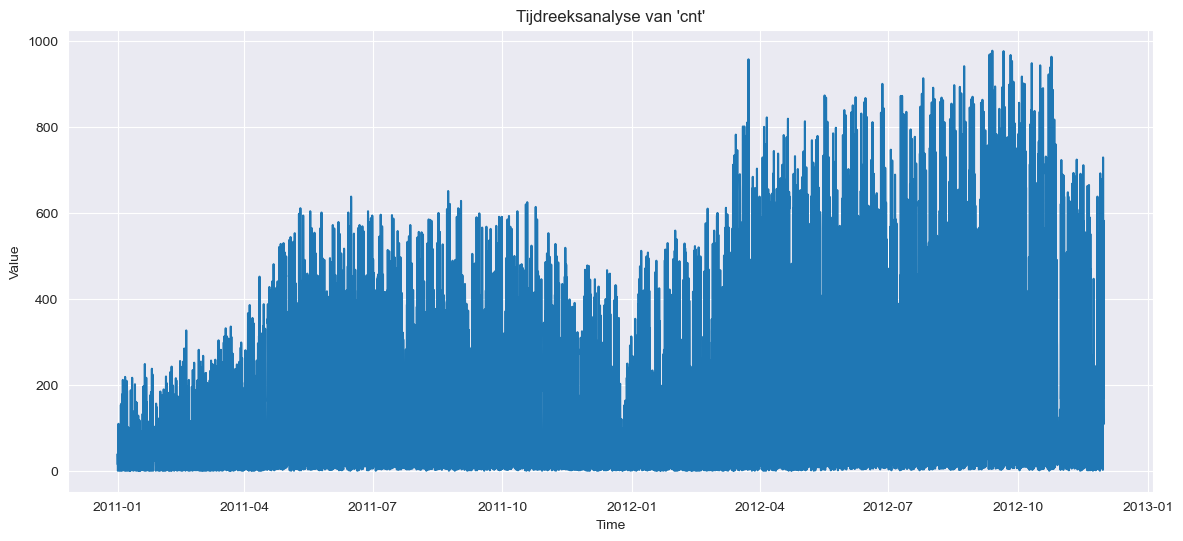

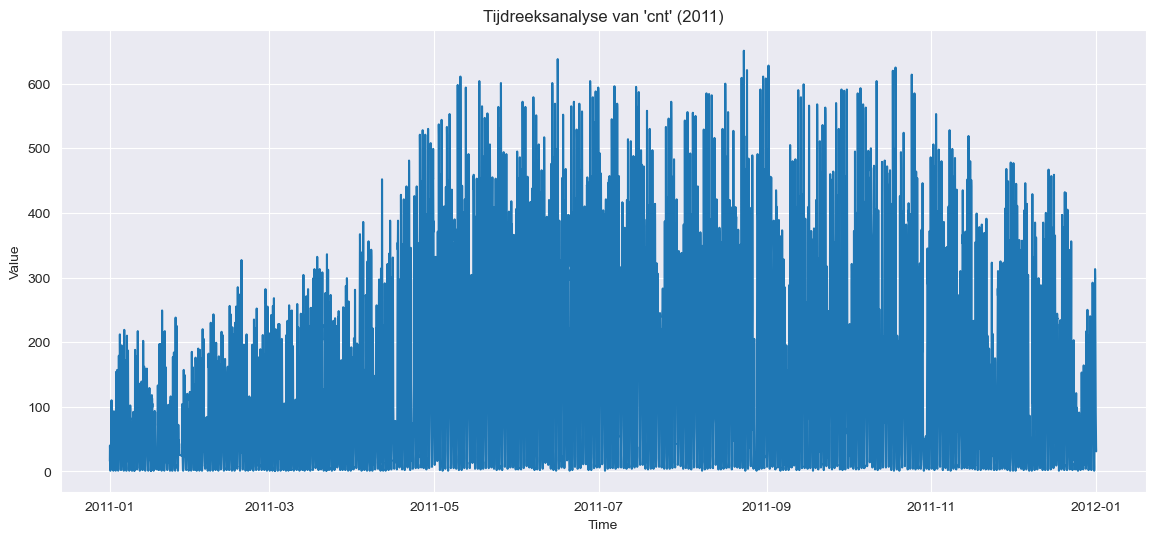

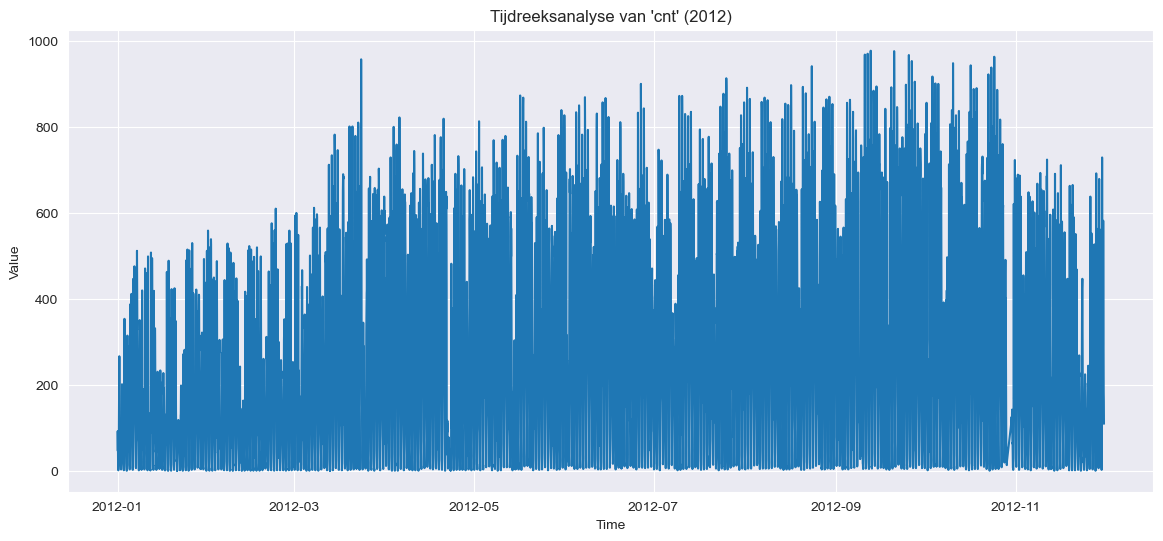

In [ ]:
visualizer.plot_time_series(value_col='cnt', title="Tijdreeksanalyse van 'cnt'")
visualizer.plot_time_series(value_col='cnt', year=2011, title="Tijdreeksanalyse van 'cnt'")
visualizer.plot_time_series(value_col='cnt', year=2012, title="Tijdreeksanalyse van 'cnt'")

### Verdeling van de kolommen

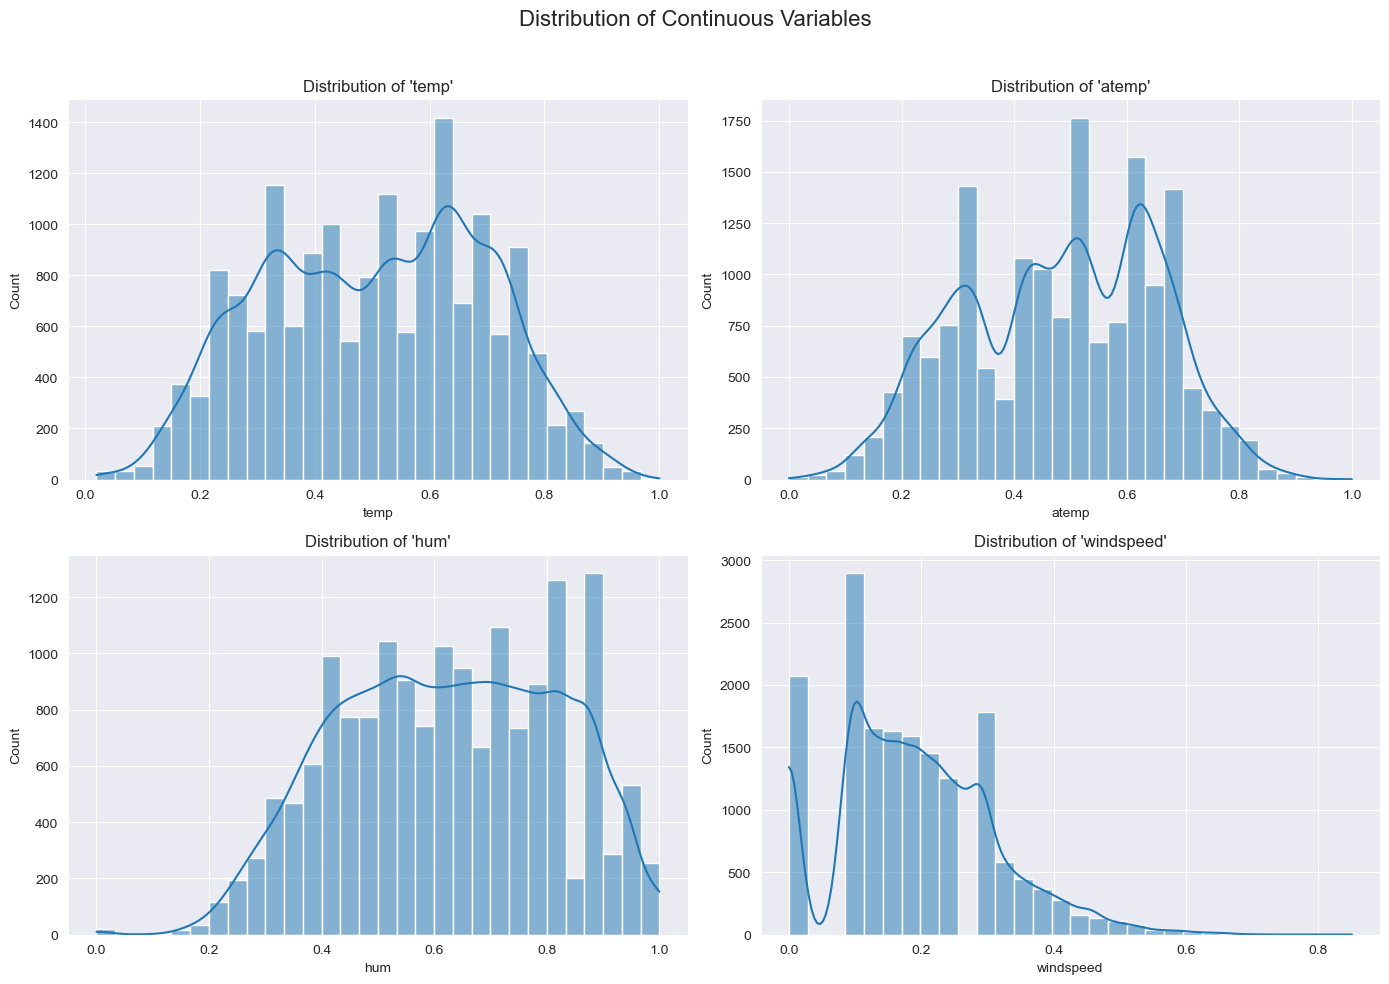

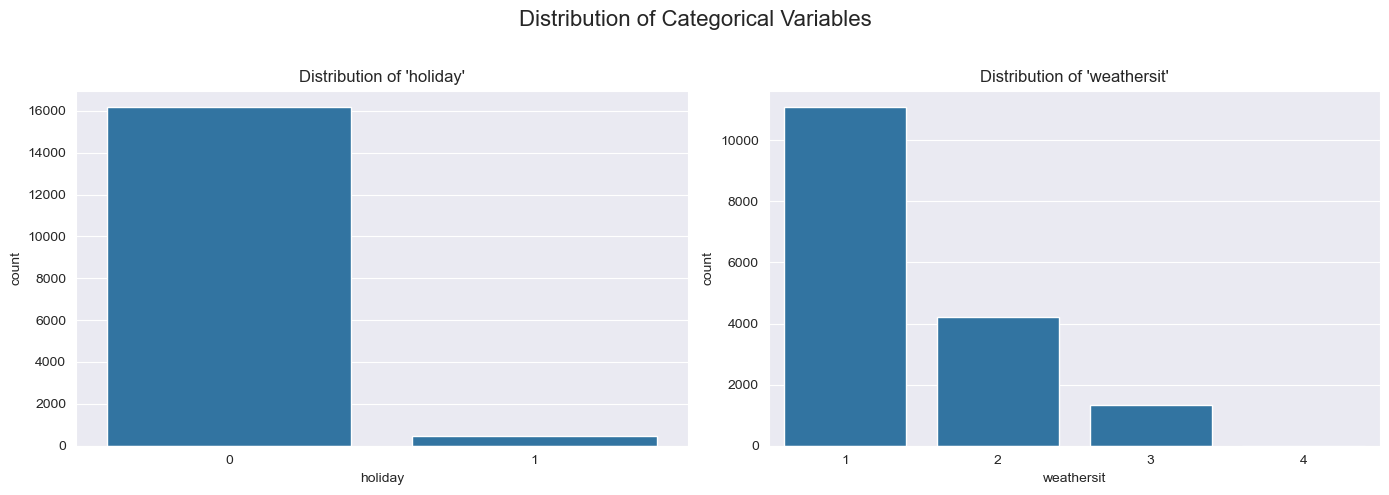

In [ ]:
visualizer.plot_distributions(continuous_cols=['temp', 'atemp', 'hum', 'windspeed'])
visualizer.plot_categorical_counts(categorical_cols=['holiday', 'weathersit'])

### Relaties

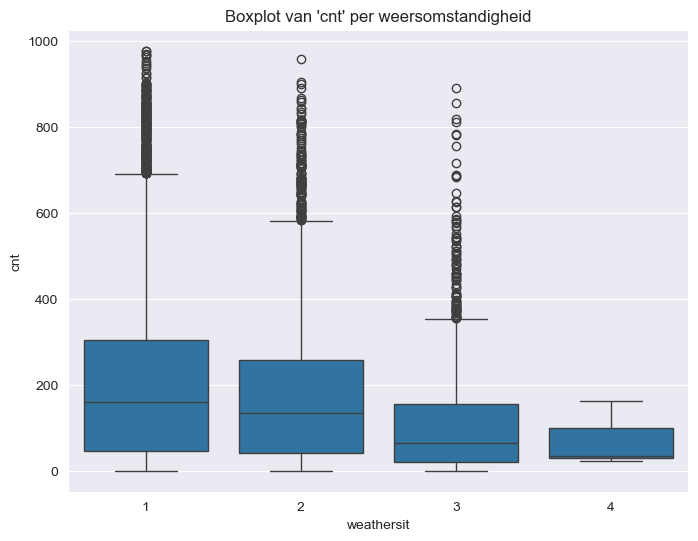

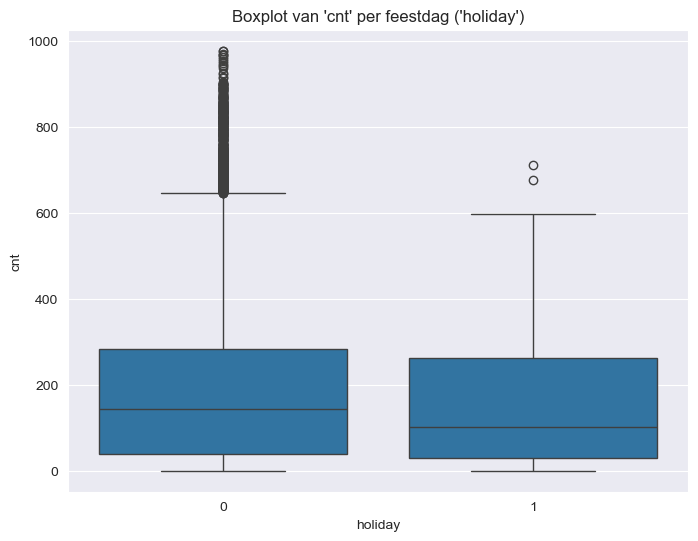

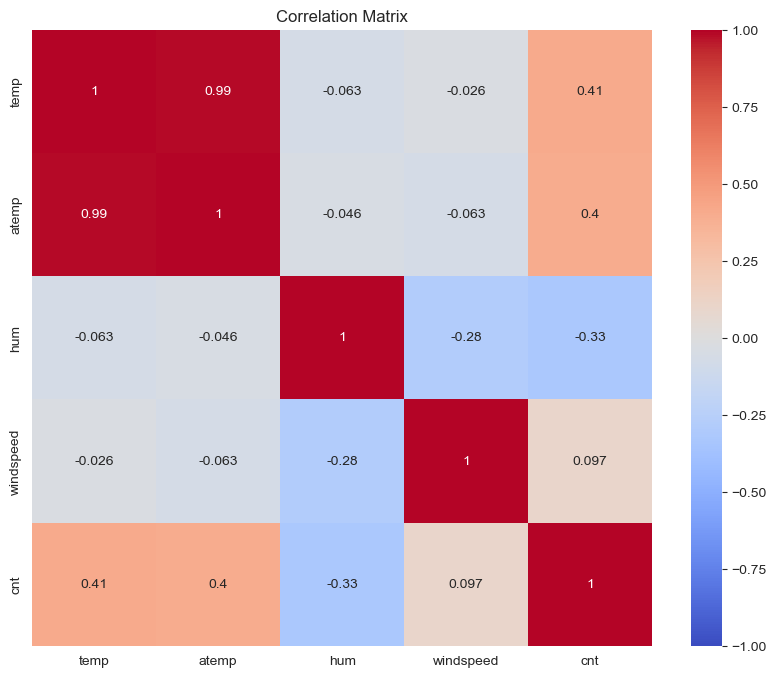

In [ ]:
visualizer.plot_boxplot(x_col='weathersit', y_col='cnt', title="Boxplot van 'cnt' per weersomstandigheid")
visualizer.plot_boxplot(x_col='holiday', y_col='cnt', title="Boxplot van 'cnt' per feestdag ('holiday')")
visualizer.plot_correlation_matrix(cols=['temp', 'atemp', 'hum', 'windspeed', 'cnt'])

**Tijdreeksanalyse van cnt:**

- Het aantal cnt neemt in de loop van de tijd toe, met duidelijke schommelingen die mogelijk verband houden met seizoenen of andere tijdsgebonden factoren.

**Verdelingsplots van continue variabelen:**

- temp en atemp hebben een bijna normale verdeling, met een piek rond 0,6.
- hum heeft een vrij gelijkmatige verdeling, maar met een lichte piek bij hogere luchtvochtigheidswaarden.
- windspeed heeft een piek bij lagere waardes, wat suggereert dat de meeste cnt lage windsnelheden hebben.
- Er blijkt heel weinig holidays te zijn
- De verdeling bij weeromstaandigheid is er te zien dat de aantallen per waarde daalt, waarbij 1 de hoogste is. 

**Boxplots van cnt per weersomstandigheid:**

- Het aantal cnt is het hoogst bij heldere weersomstandigheden en neemt af bij zwaardere weersomstandigheden. Dit suggereert dat slecht weer invloed kan hebben op de activiteit.

**Boxplots van cnt per feestdag (holiday):**

- Er zijn geen significante verschillen in cnt tussen feestdagen en gewone dagen, hoewel de variatie iets groter is op gewone dagen.

**Correlatiematrix:**

- temp en atemp zijn sterk gecorreleerd (0,99), wat logisch is omdat beide temperatuurgerelateerd zijn.
- temp en atemp vertonen een matige positieve correlatie met cnt, wat aangeeft dat hogere temperaturen mogelijk gepaard gaan met meer cnt.
- hum heeft een zwakke negatieve correlatie met cnt, wat kan betekenen dat hogere luchtvochtigheid  een negatieve invloed kan hebben op de cnt.
- temp en atemp vertonen vaak een matige positieve correlatie met cnt. Dit wijst erop dat hogere temperaturen kunnen leiden tot een toename in het aantal cnt.


#### Controle op Uitschieters

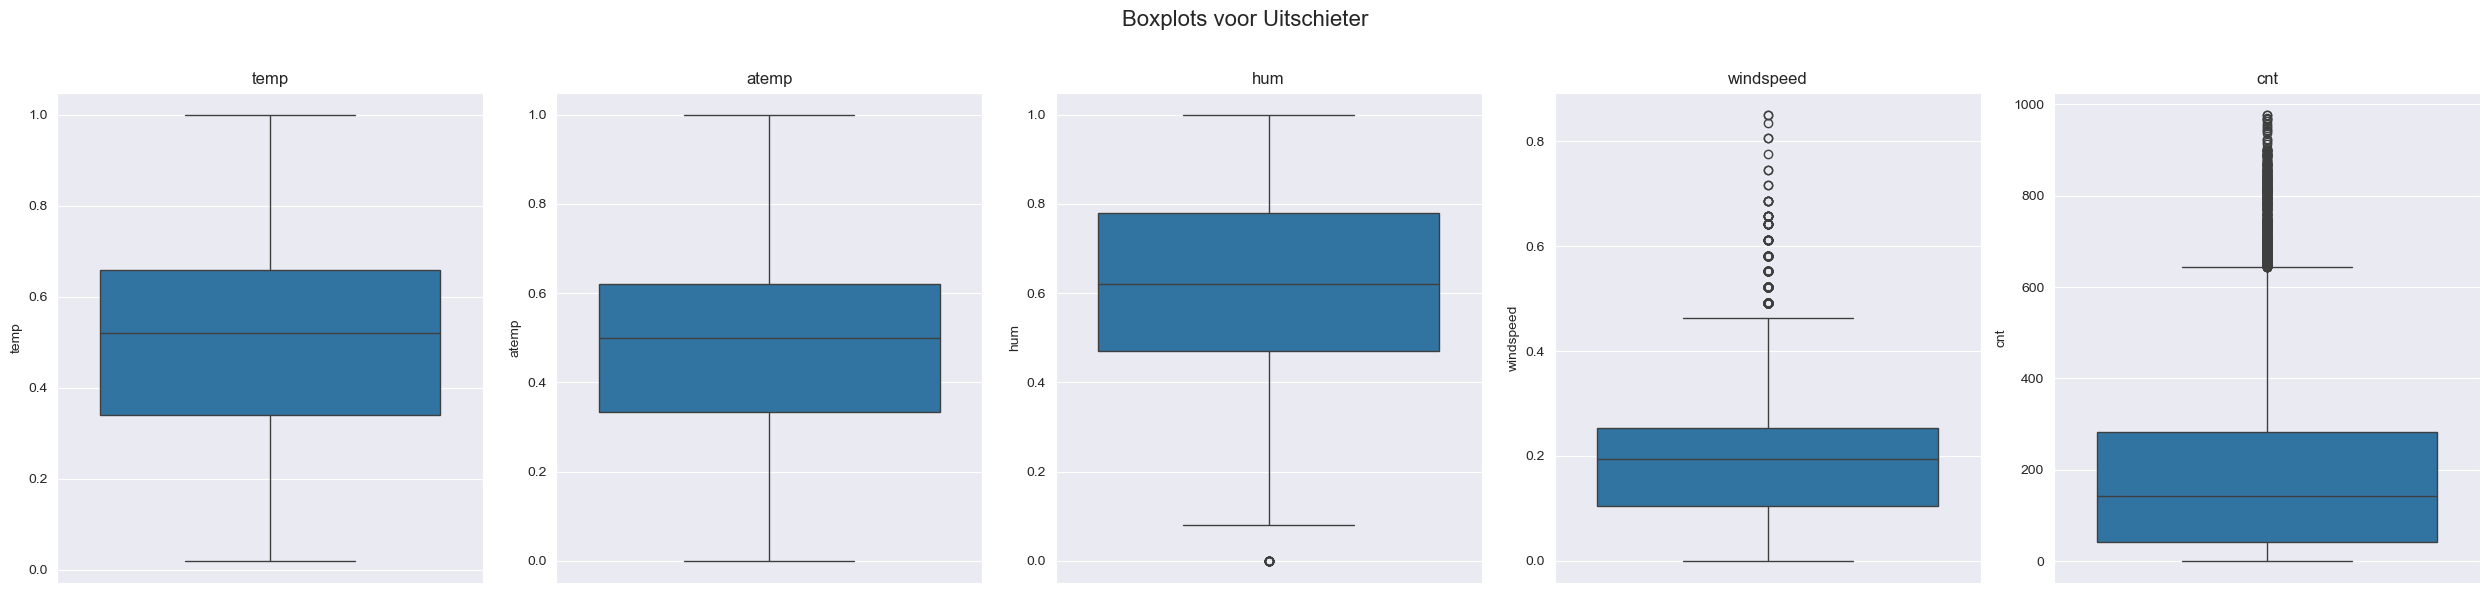

In [ ]:
# Boxplots for outliers
visualizer.plot_boxplots(cols=["temp", "atemp", "hum", "windspeed", "cnt"], 
                         title="Boxplots voor Uitschieter")

- hum: Er zijn enkele waarden dicht bij de minimumdie als outliers kunnen worden beschouwd.
- windspeed : Er zijn een paar lage waarden die als uitschieters worden beschouwd.
- cnt: Er zijn een paar hoge waarden die buiten het interkwartielbereik liggen en als uitschieters kunnen worden gezien.

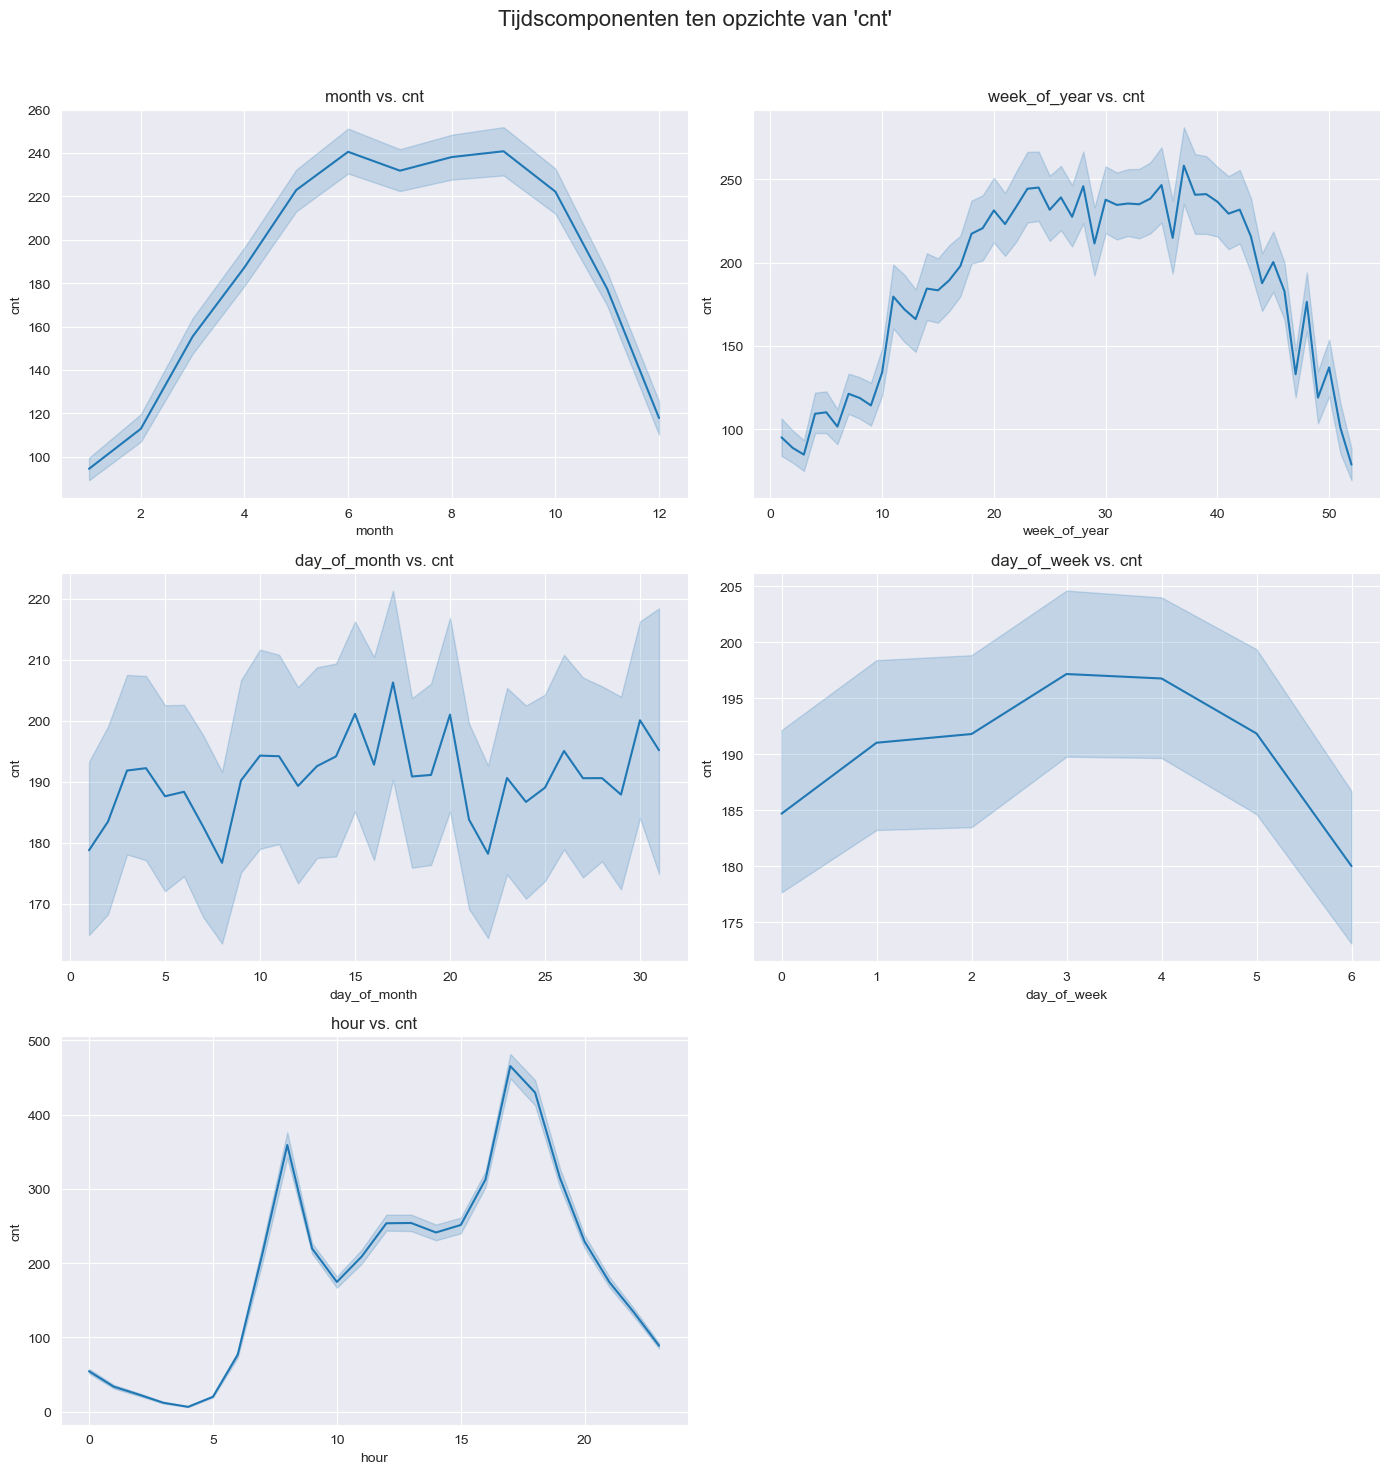

In [ ]:
# Time components vs 'cnt'
visualizer.plot_time_components_vs_cnt(time_components=['month', 'week_of_year', 'day_of_month','day_of_week', 'hour'],
                                        target_col="cnt", 
                                        title="Tijdscomponenten ten opzichte van 'cnt'")

## Feature Engineering

### Analysis

In [ ]:
class time_series_analysis:
    def __init__(self, dataframe):
        self.df = dataframe

    def periodigram(self, col='cnt', xlim=None, ylim=None, filter_amp=None):
        timeserie = self.df[col]
        n = len(timeserie)
        freq = np.fft.fftfreq(n,1)
        fft_result = fft(timeserie)

        plt.figure(figsize=(10, 6))
        plt.plot(freq, np.abs(fft_result))
        plt.xlabel('Frequency (1/hour)')
        plt.ylabel('Amplitude')
        if xlim != None:
            plt.xlim([0,0.1])
        if ylim != None:
            plt.ylim([0,1e6])
        plt.title('Periodigram')
        plt.grid(True)
        plt.show()

        df_fft = pd.DataFrame(np.abs(fft_result))
        df_fft['freq'] = freq
        hours = []
        days= []
        for f in freq:
            if f != 0:
                hours.append(1/f)
                days.append(1/f/24)
            else:
                hours.append(np.inf)
                days.append(np.inf)
        df_fft['duur in uren'] = hours
        df_fft['duur in dagen'] = days
        df_fft.rename(columns={0:'amplitude'}, inplace=True)
        if filter_amp != None:
            df_fft = df_fft[(df_fft['amplitude'] > filter_amp)&(df_fft['freq'] > 0)]
        else:
            df_fft = df_fft[df_fft['freq'] > 0]
        display(df_fft)

    def plot_autocorrelations(self, col='', lags=24):
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        # ACF plot
        plot_acf(self.df[col], ax=axes[0], lags=lags)
        axes[0].set_title("Autocorrelation Function (ACF)")

        # PACF plot
        plot_pacf(self.df[col], ax=axes[1], lags=lags)
        axes[1].set_title("Partial Autocorrelation Function (PACF)")

        plt.tight_layout()
        plt.show()

    def plot_seasonal_decompose(self, col='', model='additive', period=24):
        sd = seasonal_decompose(self.df[col], model=model, period=period)
        plt.figure(figsize=(30,6))
        plt.title("Trend")
        sd.trend.plot()
        plt.figure(figsize=(30,6))
        plt.title("Seasonal")
        sd.seasonal.plot()
        plt.figure(figsize=(30,6))
        plt.title("Resid")
        sd.resid.plot()
        plt.show()

ts_analyzer = time_series_analysis(train)

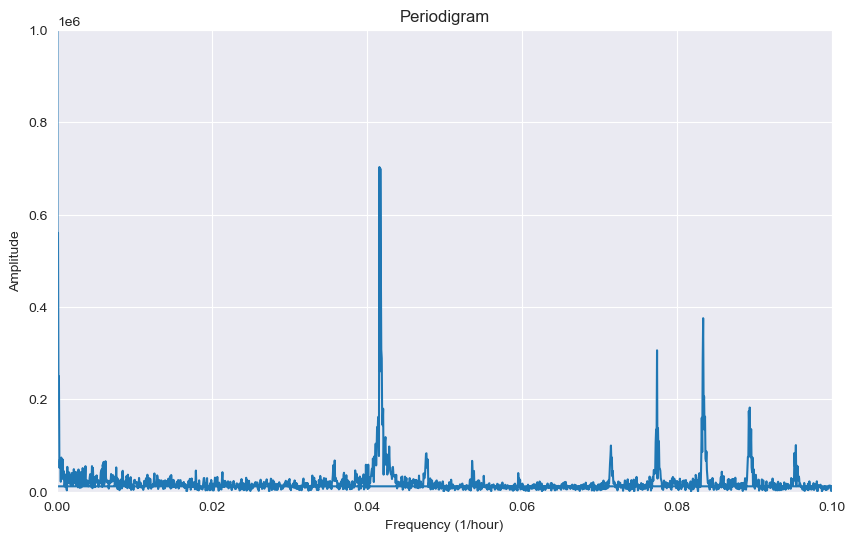

,amplitude,freq,duur in uren,duur in dagen
1,489864.299841,0.000060,16637.000000,693.208333
2,560236.241034,0.000120,8318.500000,346.604167
692,702799.953019,0.041594,24.041908,1.001746
694,699280.808600,0.041714,23.972622,0.998859
695,479527.144257,0.041774,23.938129,0.997422
696,307463.826990,0.041834,23.903736,0.995989
1288,306064.251401,0.077418,12.916925,0.538205
1387,375575.609672,0.083368,11.994953,0.499790


In [ ]:
ts_analyzer.periodigram(xlim=[0,0.1], ylim=[0,1e6], filter_amp=0.3e+06)

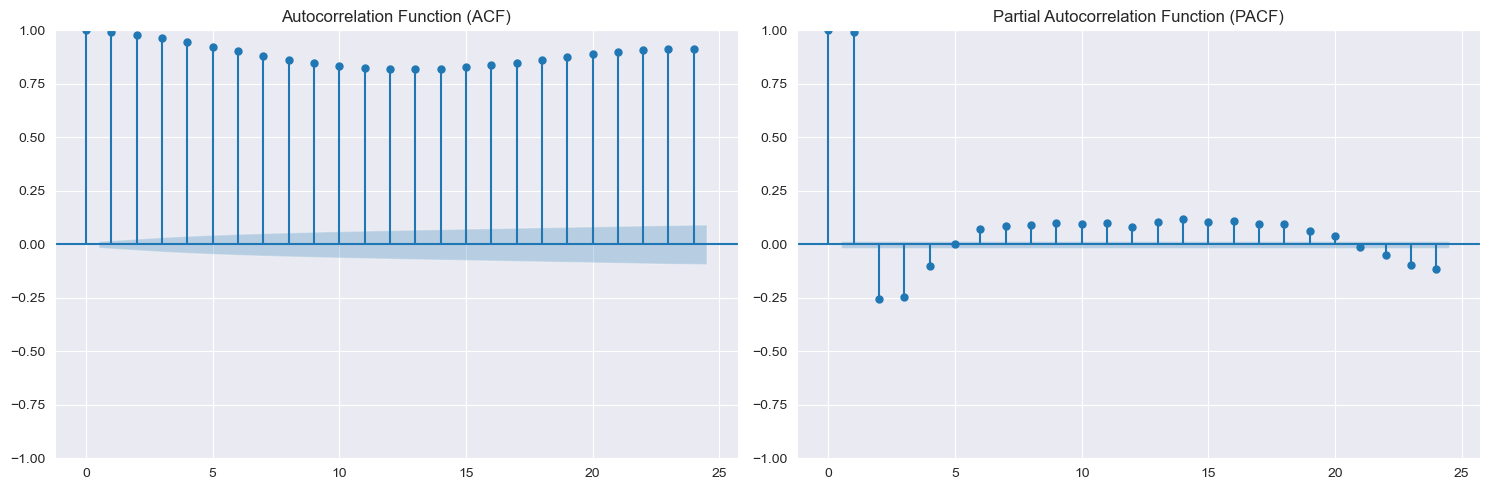

In [ ]:
ts_analyzer.plot_autocorrelations(col='temp', lags=24)

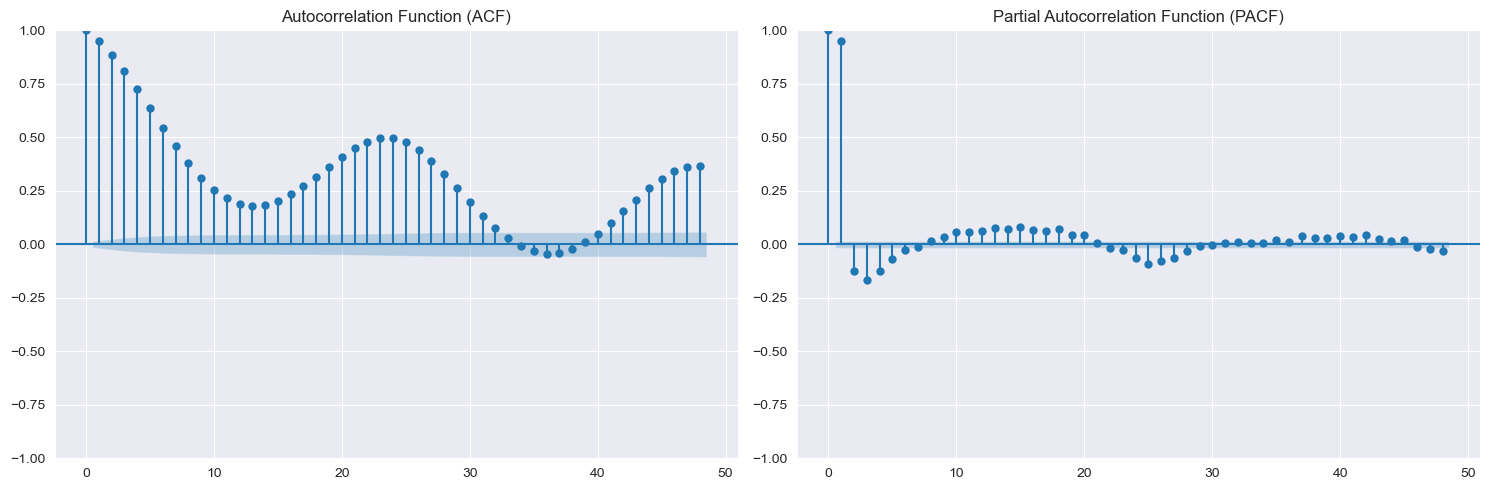

In [ ]:
ts_analyzer.plot_autocorrelations(col='hum', lags=48)

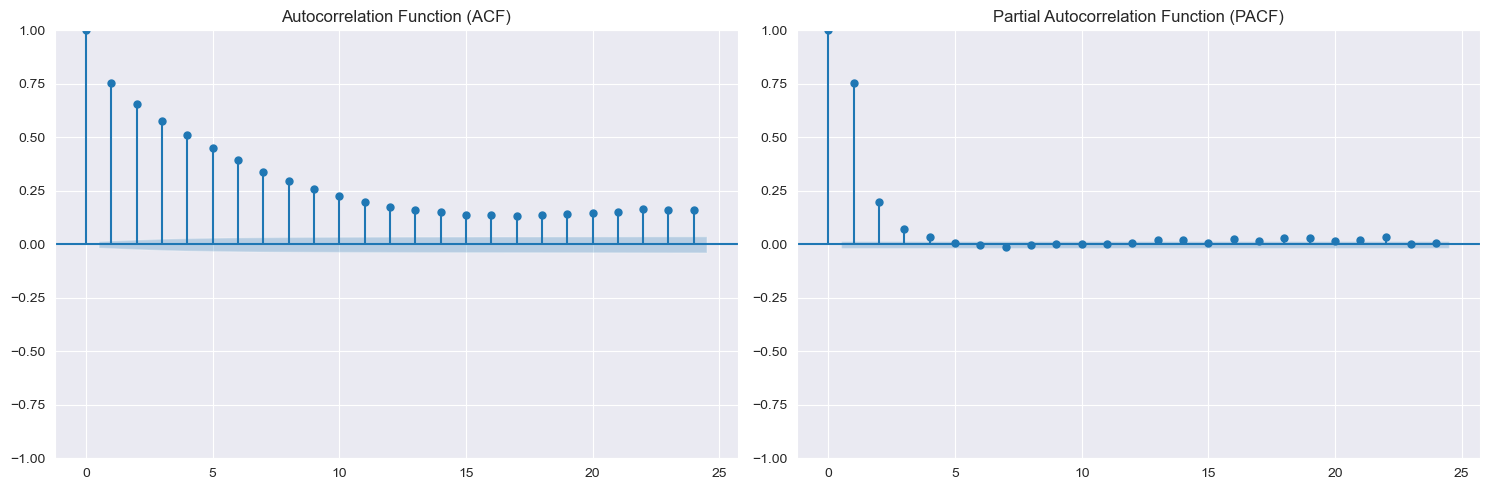

In [ ]:
ts_analyzer.plot_autocorrelations(col='windspeed', lags=24)

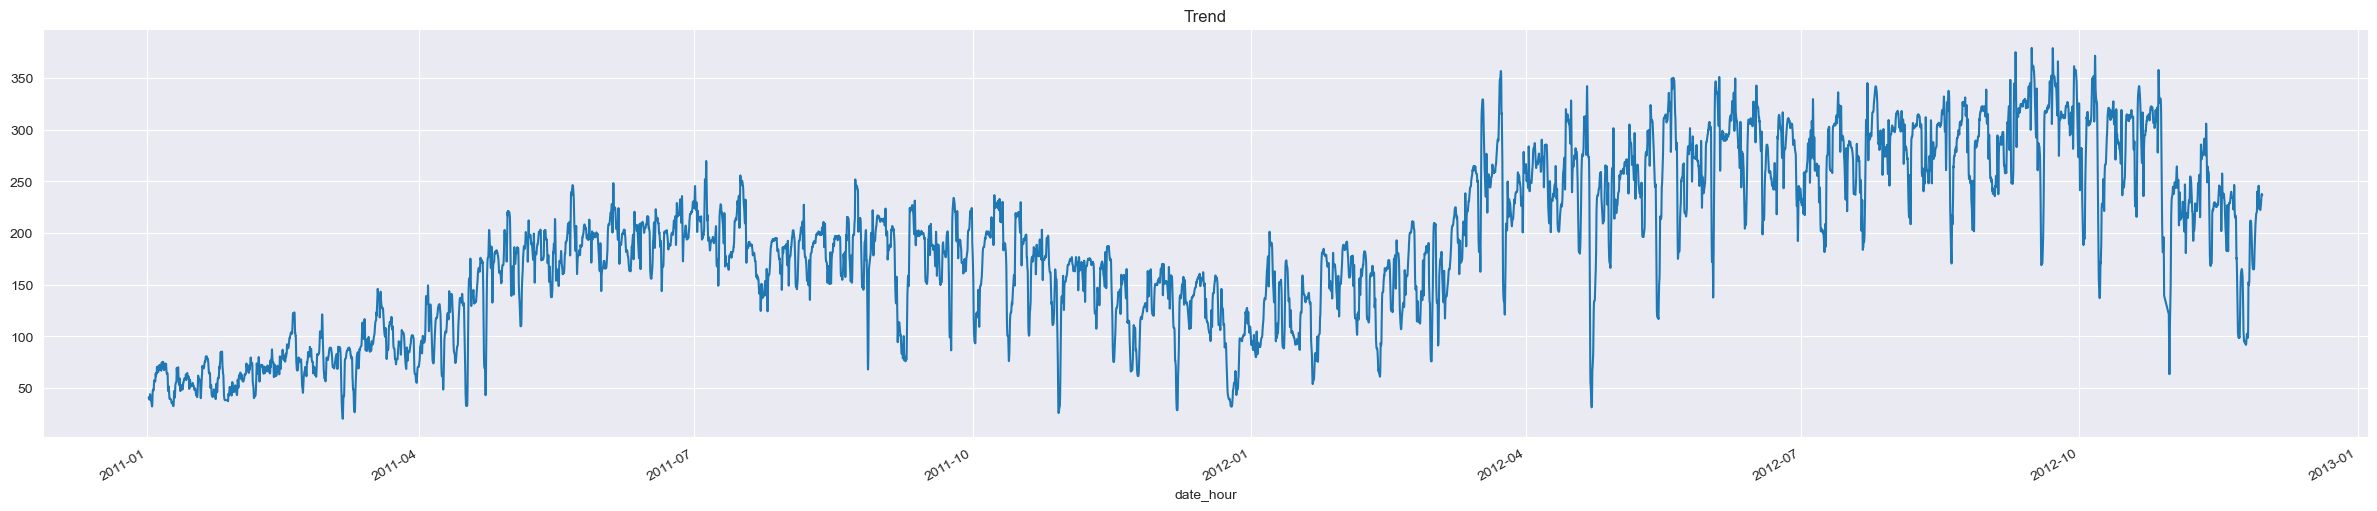

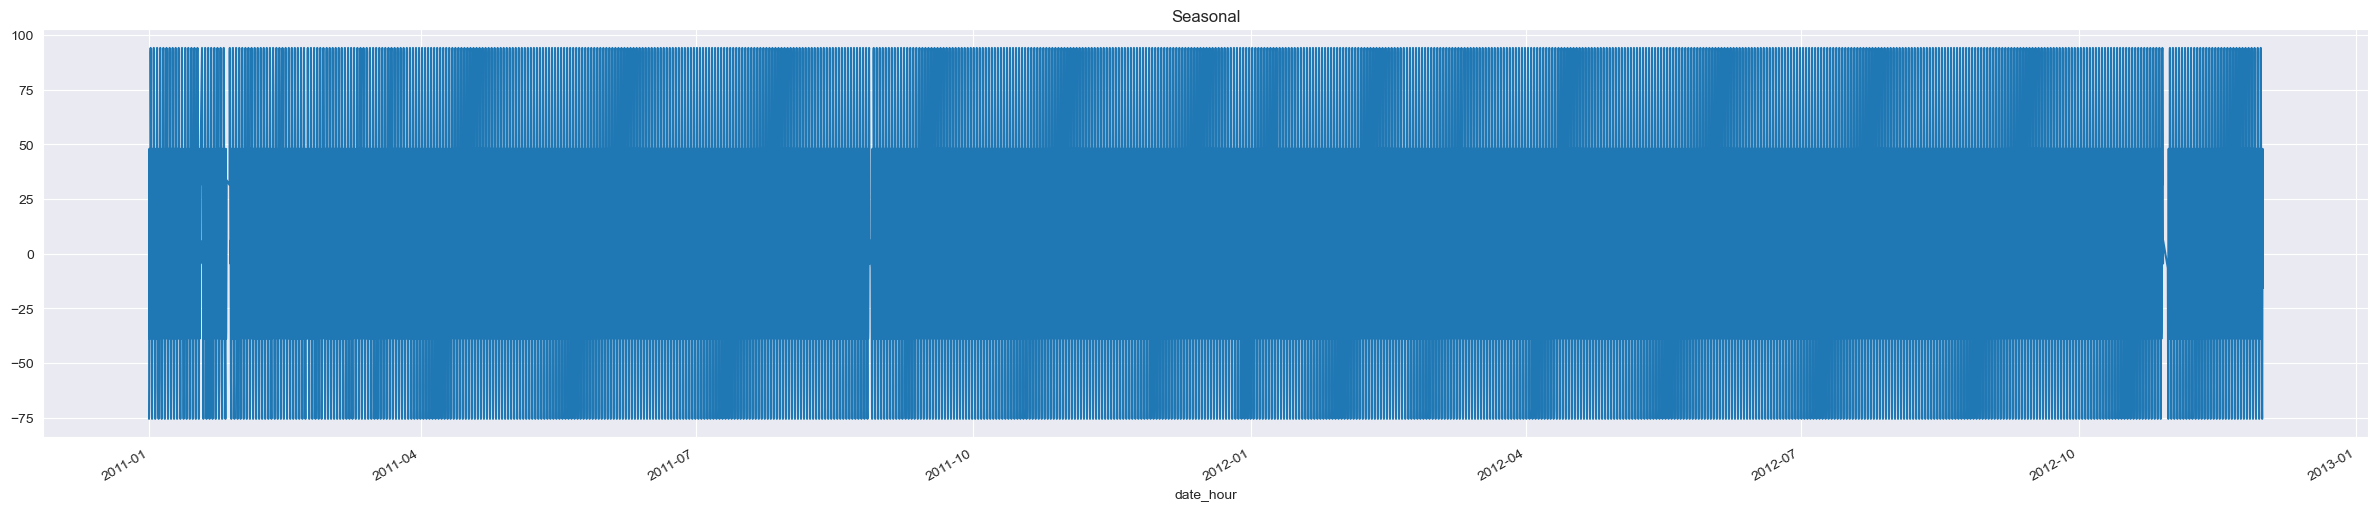

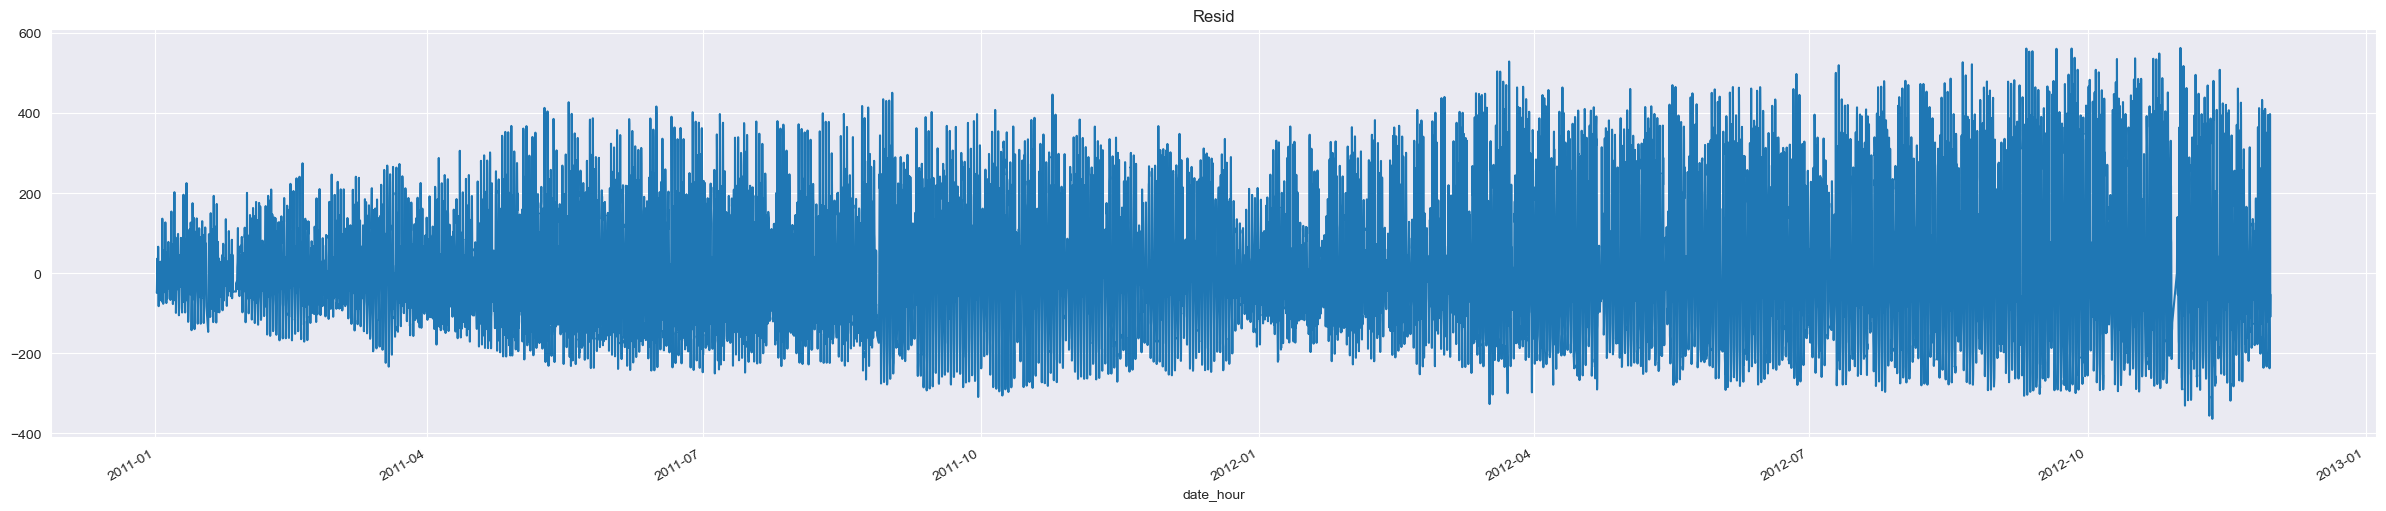

In [ ]:
ts_analyzer.plot_seasonal_decompose(col='cnt', model='additive', period=24)

### Time Series Feature Engineering

In [ ]:
class time_series_feature_engineering:
    def __init__(self, train, test, target=''):
        # Ensure the dataframe has a datetime index
        if not isinstance(train.index, pd.DatetimeIndex):
            raise ValueError("The train dataframe index must be a DatetimeIndex.")
        if not isinstance(test.index, pd.DatetimeIndex):
            raise ValueError("The test dataframe index must be a DatetimeIndex.")
        
        self.df = train.copy()
        self.X_train = self.df.drop(target, axis=1)
        self.y_train = self.df[target]
        self.test = test.copy()

        # Generate features for train data
        self.X_train['year'] = self.X_train.index.year
        self.X_train['month'] = self.X_train.index.month
        self.X_train['week_of_year'] = self.X_train.index.isocalendar().week
        self.X_train['day_of_year'] = self.X_train.index.day_of_year
        self.X_train['day_of_month'] = self.X_train.index.day
        self.X_train['day_of_week'] = self.X_train.index.weekday  # 0=Monday, 6=Sunday
        self.X_train['hour'] = self.X_train.index.hour
        self.X_train['is_weekend'] = self.X_train.index.weekday >= 5  # Boolean feature for weekends
        self.X_train['quarter'] = self.X_train.index.quarter
        self.X_train['season'] = self.X_train['month'].apply(self.get_season)
        self.X_train['day_name'] = self.X_train.index.day_name()
        self.X_train = pd.get_dummies(self.X_train, columns=['season','day_name'], prefix=['season','day_name'])
        
        # Generate features for test data
        self.test['year'] = self.test.index.year
        self.test['month'] = self.test.index.month
        self.test['week_of_year'] = self.test.index.isocalendar().week
        self.test['day_of_year'] = self.test.index.day_of_year
        self.test['day_of_month'] = self.test.index.day
        self.test['day_of_week'] = self.test.index.weekday
        self.test['hour'] = self.test.index.hour
        self.test['is_weekend'] = self.test.index.weekday >= 5
        self.test['quarter'] = self.test.index.quarter
        self.test['season'] = self.test['month'].apply(self.get_season)
        self.test['day_name'] = self.test.index.day_name()
        self.test = pd.get_dummies(self.test, columns=['season','day_name'], prefix=['season','day_name'])

        # Align test and train columns
        self.X_train, self.test = self.X_train.align(self.test, join='left', axis=1, fill_value=0)

        self.X_train = self.X_train.astype({col: 'int' for col in self.X_train.select_dtypes(include='bool').columns})
        self.test = self.test.astype({col: 'int' for col in self.test.select_dtypes(include='bool').columns})

        # Check for missing values and warn
        self.check_missing_values(self.X_train, "Training Data")
        self.check_missing_values(self.test, "Test Data")

    def get_season(self, month):
        """Returns the season for a given month."""
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        elif month in [9, 10, 11]:
            return 'Autumn'

    def check_missing_values(self, df, name):
        """Check for missing values and print a warning if any are found."""
        missing_values = df.isnull().sum()
        if missing_values.any():
            print(f"Warning: Missing values found in {name}:")
            print(missing_values[missing_values > 0])

    def add_fourier_feature(self, freqs, order, constant=False, seasonal=False, drop=True):  
        # Ensure freqs is a list
        if not isinstance(freqs, list):
            freqs = [freqs]  # If a single freq is provided, make it a list

        fourier_terms = []
        for freq in freqs:
            fourier_terms.append(CalendarFourier(freq=freq, order=order))

        dp = DeterministicProcess(index=self.X_train.index, constant=constant, order=order, seasonal=seasonal,
                                        additional_terms=fourier_terms, drop=drop)
            
        X_train2 = dp.in_sample()
        test2 = dp.out_of_sample(steps=len(self.test), forecast_index=self.test.index)

        self.X_train = pd.concat([self.X_train, X_train2], axis=1)
        self.test = pd.concat([self.test, test2], axis=1)

        # Check for missing values after adding Fourier features
        self.check_missing_values(self.X_train, "Training Data")
        self.check_missing_values(self.test, "Test Data")
    
    def lag_feature(self, column='', lags=int):
        """
        Creates lag features for a given column in the training and test datasets.
        
        Args:
            column (str): The column to create lag features for.
            lags (list or int or range): A list, range, or single integer specifying the lag values.
        """
        if isinstance(lags, int):  # If a single integer is provided
            lags = [lags]
        elif isinstance(lags, range):  # If a range is provided
            lags = list(lags)
        
        for lag in lags:
            self.X_train[f'{column}_lag_{lag}'] = self.X_train[column].shift(lag)
            self.test[f'{column}_lag_{lag}'] = self.test[column].shift(lag)

        # Ensure rows with missing lag values are handled properly in both datasets
        self.X_train = self.X_train.dropna(subset=[f'{column}_lag_{lag}' for lag in lags])
        self.y_train = self.y_train.loc[self.X_train.index]
        self.test = self.test.dropna(subset=[f'{column}_lag_{lag}' for lag in lags])

        # Check for missing values after creating lag features
        self.check_missing_values(self.X_train, "Training Data")
        self.check_missing_values(self.test, "Test Data")

ts_fe = time_series_feature_engineering(train, test, target='cnt')

In [ ]:
ts_fe.add_fourier_feature(freqs=['YE','D'], order=1)

In [ ]:
ts_fe.lag_feature('temp', 1)
ts_fe.lag_feature('hum', 1)

In [ ]:
display(ts_fe.X_train.head(10), ts_fe.test.head(10))

,holiday,weathersit,temp,atemp,hum,windspeed,year,month,week_of_year,day_of_year,day_of_month,day_of_week,hour,is_weekend,quarter,season_Autumn,season_Spring,season_Summer,season_Winter,day_name_Friday,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday,trend,"sin(1,freq=YE-DEC)","cos(1,freq=YE-DEC)","sin(1,freq=D)","cos(1,freq=D)",temp_lag_1,hum_lag_1
date_hour,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0000,2011,1,52,1,1,5,2,1,1,0,0,0,1,0,0,1,0,0,0,0,3.0,0.001435,0.999999,0.500000,8.660254e-01,0.22,0.80
2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0000,2011,1,52,1,1,5,3,1,1,0,0,0,1,0,0,1,0,0,0,0,4.0,0.002152,0.999998,0.707107,7.071068e-01,0.22,0.80
2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0000,2011,1,52,1,1,5,4,1,1,0,0,0,1,0,0,1,0,0,0,0,5.0,0.002869,0.999996,0.866025,5.000000e-01,0.24,0.75
2011-01-01 05:00:00,0,2,0.24,0.2576,0.75,0.0896,2011,1,52,1,1,5,5,1,1,0,0,0,1,0,0,1,0,0,0,0,6.0,0.003586,0.999994,0.965926,2.588190e-01,0.24,0.75
2011-01-01 06:00:00,0,1,0.22,0.2727,0.80,0.0000,2011,1,52,1,1,5,6,1,1,0,0,0,1,0,0,1,0,0,0,0,7.0,0.004304,0.999991,1.000000,6.123234e-17,0.24,0.75
2011-01-01 07:00:00,0,1,0.20,0.2576,0.86,0.0000,2011,1,52,1,1,5,7,1,1,0,0,0,1,0,0,1,0,0,0,0,8.0,0.005021,0.999987,0.965926,-2.588190e-01,0.22,0.80
2011-01-01 08:00:00,0,1,0.24,0.2879,0.75,0.0000,2011,1,52,1,1,5,8,1,1,0,0,0,1,0,0,1,0,0,0,0,9.0,0.005738,0.999984,0.866025,-5.000000e-01,0.20,0.86
2011-01-01 09:00:00,0,1,0.32,0.3485,0.76,0.0000,2011,1,52,1,1,5,9,1,1,0,0,0,1,0,0,1,0,0,0,0,10.0,0.006455,0.999979,0.707107,-7.071068e-01,0.24,0.75
2011-01-01 10:00:00,0,1,0.38,0.3939,0.76,0.2537,2011,1,52,1,1,5,10,1,1,0,0,0,1,0,0,1,0,0,0,0,11.0,0.007173,0.999974,0.500000,-8.660254e-01,0.32,0.76


,holiday,weathersit,temp,atemp,hum,windspeed,year,month,week_of_year,day_of_year,day_of_month,day_of_week,hour,is_weekend,quarter,season_Autumn,season_Spring,season_Summer,season_Winter,day_name_Friday,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday,trend,"sin(1,freq=YE-DEC)","cos(1,freq=YE-DEC)","sin(1,freq=D)","cos(1,freq=D)",temp_lag_1,hum_lag_1
date_hour,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-12-01 02:00:00,0,2,0.26,0.3030,0.81,0.0000,2012,12,48,336,1,5,2,1,4,0,0,0,1,0,0,1,0,0,0,0,16640.0,-0.506182,0.862427,0.500000,8.660254e-01,0.26,0.81
2012-12-01 03:00:00,0,2,0.26,0.2727,0.81,0.1343,2012,12,48,336,1,5,3,1,4,0,0,0,1,0,0,1,0,0,0,0,16641.0,-0.505565,0.862789,0.707107,7.071068e-01,0.26,0.81
2012-12-01 04:00:00,0,1,0.26,0.2879,0.81,0.0896,2012,12,48,336,1,5,4,1,4,0,0,0,1,0,0,1,0,0,0,0,16642.0,-0.504948,0.863150,0.866025,5.000000e-01,0.26,0.81
2012-12-01 05:00:00,0,1,0.24,0.2576,0.87,0.0896,2012,12,48,336,1,5,5,1,4,0,0,0,1,0,0,1,0,0,0,0,16643.0,-0.504330,0.863511,0.965926,2.588190e-01,0.26,0.81
2012-12-01 06:00:00,0,1,0.24,0.2424,0.87,0.1343,2012,12,48,336,1,5,6,1,4,0,0,0,1,0,0,1,0,0,0,0,16644.0,-0.503712,0.863872,1.000000,6.123234e-17,0.24,0.87
2012-12-01 07:00:00,0,2,0.24,0.2424,0.87,0.1343,2012,12,48,336,1,5,7,1,4,0,0,0,1,0,0,1,0,0,0,0,16645.0,-0.503094,0.864232,0.965926,-2.588190e-01,0.24,0.87
2012-12-01 08:00:00,0,2,0.24,0.2424,0.87,0.1343,2012,12,48,336,1,5,8,1,4,0,0,0,1,0,0,1,0,0,0,0,16646.0,-0.502476,0.864591,0.866025,-5.000000e-01,0.24,0.87
2012-12-01 09:00:00,0,2,0.26,0.2424,0.93,0.2537,2012,12,48,336,1,5,9,1,4,0,0,0,1,0,0,1,0,0,0,0,16647.0,-0.501857,0.864950,0.707107,-7.071068e-01,0.24,0.87
2012-12-01 10:00:00,0,2,0.28,0.2727,0.89,0.1642,2012,12,48,336,1,5,10,1,4,0,0,0,1,0,0,1,0,0,0,0,16648.0,-0.501238,0.865309,0.500000,-8.660254e-01,0.26,0.93


## Modeling

In [ ]:
X_train = ts_fe.X_train.copy()
y_train = ts_fe.y_train.copy()

### Ensembles

Ensemble learning is een techniek binnen machine learning waarbij de voorspellingen van meerdere modellen worden gecombineerd om tot een betere prestatie te komen dan een enkel model zou kunnen bereiken. Het idee is om de kracht van verschillende modellen te bundelen door hun resultaten samen te voegen. Elk model heeft zijn eigen sterke en zwakke punten, en door ze te combineren, hopen we de nauwkeurigheid, robuustheid en generalisatie van onze voorspellingen te verbeteren.

Er zijn verschillende methoden om ensemble leren toe te passen:

Bagging (Bootstrap Aggregating): Dit houdt in dat we meerdere versies van een model trainen op verschillende subsets van de trainingsdata. Deze subsets worden willekeurig geselecteerd met teruglegging, zodat sommige voorbeelden vaker voorkomen en andere juist helemaal niet. Elk model wordt onafhankelijk getraind, en de uiteindelijke voorspelling komt tot stand door bijvoorbeeld meerderheidsstemmen (bij classificatie) of het gemiddelde van de voorspellingen (bij regressie). Een bekend voorbeeld van een bagging-algoritme is Random Forest.

Boosting: Bij boosting worden modellen na elkaar getraind. Elk nieuw model probeert de fouten van het vorige model te corrigeren door meer nadruk te leggen op de voorbeelden die eerder verkeerd geclassificeerd werden. Algoritmen zoals AdaBoost, Gradient Boosting en XGBoost maken gebruik van deze aanpak.

Stacking: Stacking is een methode waarbij we meerdere basismodellen gebruiken en hun voorspellingen combineren met behulp van een meta-model. Dit meta-model wordt getraind om de output van de basismodellen zo goed mogelijk samen te voegen om tot een betere uiteindelijke voorspelling te komen.

Door deze technieken toe te passen in ons project, kunnen we het risico op overfitting verminderen en de nauwkeurigheid van ons model verhogen. Ensemble-methoden zijn dan ook populair in de praktijk en worden veel gebruikt bij machine learning-competities, omdat ze vaak betere resultaten opleveren dan individuele modellen.  
[(GeeksforGeeks, 2023h)](https://www.geeksforgeeks.org/a-comprehensive-guide-to-ensemble-learning/)

#### Gradient Boost

Gradient Boosting is een machine learning-techniek die stap voor stap beter wordt. Het begint met een simpel model dat een gemiddelde voorspelt. Daarna berekent het de fouten (de residuen) en gebruikt die om een nieuw model te trainen. Dit proces herhaalt zich totdat de fouten heel klein zijn. Het gebruikt een wiskundige techniek, genaamd gradient descent, om deze fouten steeds kleiner te maken. Hierdoor kan het sterke voorspellingen doen, maar het kan wel traag zijn bij grote datasets.  
[(GeeksforGeeks, 2023b)](https://www.geeksforgeeks.org/boosting-in-machine-learning-boosting-and-adaboost/)

In [ ]:
gb_model = GradientBoostingRegressor(loss='squared_error', learning_rate=0.01, n_estimators=200, criterion='friedman_mse', max_depth=10)
gb_model.fit(X_train, y_train)

gb_score = cross_val_score(gb_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1, verbose=1).mean()
print(f"GB score: {gb_score}")

In [ ]:
gb_params = {
    'loss':{'squared_error', 'absolute_error', 'huber', 'quantile'},
    'learning_rate':{0.001, 0.01, 0.1},
    'n_estimators':{50, 100, 250, 500},
    'criterion':{'friedman_mse','squared_error'},
    'min_sample_split':{2,3,4,5},
    'min_sample_leaf':{1,2,3,4,5},
    'max_depth':{3,5,10},
    'max_features':{None,'sqrt','log2'},
    'warm_start':{False, True}
}

gb_model = GradientBoostingRegressor()
gridsearch = GridSearchCV(gb_model, gb_params, cv=5, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)
gridsearch.fit(X_train, y_train)

print(f"Best Parameters: {gridsearch.best_params_}")

gb_tuned = gridsearch.best_estimator_

gb_score = cross_val_score(gb_tuned, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1, verbose=1).mean()
print(f"GB score: {gb_score}")

#### XGBoost

XGBoost is een verbeterde versie van Gradient Boosting. Het is sneller en nauwkeuriger, omdat het een techniek gebruikt die *regularisatie* heet. Dit voorkomt dat het model te ingewikkeld wordt (overfitting). XGBoost gebruikt ook slimme technieken, zoals parallel werken en efficiënt omgaan met grote hoeveelheden data. Hierdoor is het heel populair, vooral bij grote projecten.  
[(GeeksforGeeks, 2023b)](https://www.geeksforgeeks.org/boosting-in-machine-learning-boosting-and-adaboost/)

In [ ]:
xgb_model = XGBRegressor(tree_method='hist')  # Specify a fast training method
xgb_model.fit(X_train, y_train)

xgb_score = cross_val_score(xgb_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1, verbose=1).mean()
print("XGBoost CV Score:", xgb_score)

In [ ]:
xgb_params = {
    'objective': ['reg:squarederror', 'reg:absoluteerror'],
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [50, 100, 250, 500],
    'max_depth': [3, 5, 10],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1, 5],
}

xgb_model = XGBRegressor(tree_method='hist') 
xgb_gridsearch = GridSearchCV(xgb_model, xgb_params, cv=5, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)
xgb_gridsearch.fit(X_train, y_train)

print("Best Parameters for XGBoost:", xgb_gridsearch.best_params_)

xgb_tuned = xgb_gridsearch.best_estimator_
xgb_score = cross_val_score(xgb_tuned, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1, verbose=1).mean()
print("XGBoost CV Score:", xgb_score)

#### AdaBoost

AdaBoost werkt ook stap voor stap, maar richt zich vooral op de moeilijkste fouten. Een belangrijk onderdeel van AdaBoost is de alpha-parameter. Deze parameter bepaalt hoeveel invloed elk zwak model heeft op het eindresultaat. Als een zwak model weinig fouten maakt, krijgt het een hogere alpha-waarde en heeft het meer gewicht in het totale model. Als een model veel fouten maakt, krijgt het een lagere alpha-waarde en minder invloed. Hierdoor focust AdaBoost zich op de moeilijkere delen van de data en probeert deze beter te voorspellen. Dit is handig voor simpele problemen, maar minder geschikt als er veel ruis in de data zit.  
[(GeeksforGeeks, 2023b)](https://www.geeksforgeeks.org/boosting-in-machine-learning-boosting-and-adaboost/)

In [ ]:
ada_model = AdaBoostRegressor()
ada_model.fit(X_train, y_train)

ada_score = cross_val_score(ada_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1, verbose=1).mean()
print("AdaBoost CV Score:", ada_score)

In [ ]:
ada_params = {
    'n_estimators': [50, 100, 250, 500],
    'learning_rate': [0.001, 0.01, 0.1, 1],
    'loss': ['linear', 'square', 'exponential']
}

ada_model = AdaBoostRegressor()
ada_gridsearch = GridSearchCV(ada_model, ada_params, cv=5, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)
ada_gridsearch.fit(X_train, y_train)

print("Best Parameters for AdaBoost:", ada_gridsearch.best_params_)

ada_tuned = ada_gridsearch.best_estimator_
ada_score = cross_val_score(ada_tuned, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1, verbose=1).mean()
print("AdaBoost CV Score:", ada_score)

#### Stacking

Stacking is een techniek in machine learning waarbij we meerdere modellen combineren om betere voorspellingen te maken. Het bestaat uit twee lagen:
- Eerste laag: Hier gebruiken we verschillende "basis-modellen" (bijvoorbeeld een beslissingboom, een lineaire regressie, of een random forest). Deze modellen maken elk een voorspelling op basis van dezelfde data.
- Tweede laag: De voorspellingen van de modellen uit de eerste laag worden doorgegeven aan een nieuw model, de "meta-classifier" of "meta-regressor". Dit model leert van de combinaties van voorspellingen van de eerste laag en maakt zo een nieuwe, verbeterde voorspelling.

![Stacking Architecture](https://media.geeksforgeeks.org/wp-content/uploads/20200713234827/mlxtend.PNG)  
[(GeeksforGeeks, 2021)](https://www.geeksforgeeks.org/stacking-in-machine-learning-2/)

In [ ]:
base_models = [
    ('xgb', XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)),
    ('gbr', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)),
    ('ada', AdaBoostRegressor(n_estimators=100, learning_rate=0.1)),
]

# Define meta-model
meta_model = LinearRegression(alpha=1.0)

# Define Stacking Regressor
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5, n_jobs=-1)

# Fit Stacking Model
stacking_model.fit(X_train, y_train)

# Evaluate with cross-validation
stacking_score = cross_val_score(stacking_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1, verbose=1).mean()
print("Stacking Model CV Score:", stacking_score)

### Bayesian

## Results

In [ ]:
def submission(model, test, file_name='submission'):
    '''Makes prediction on the test data and makes a csv containing the id and predictions.
    This is used to make a csv file to submit in the kaggle competition.

    Parameters:
        model: the trained model.
        file_name (str): name of the csv file. On default: 'submission'
    '''
    TEST = test.copy()
    y_pred = model.predict(TEST)
    copy_test = TEST.copy()
    copy_test['cnt'] = y_pred
    sub = copy_test[['cnt']].reset_index()

    os.makedirs('predictions', exist_ok=True)

    csv_file = f'predictions/{file_name}.csv'
    sub.to_csv(csv_file, index=False)
    print(f'Submission saved to {csv_file}')

In [ ]:
# submission(model, ts_fe.test, file_name='')

## Conclusion & Advice

## Sources

- GeeksforGeeks. (2023b, mei 23). Boosting in Machine Learning | Boosting and AdaBoost. GeeksforGeeks. https://www.geeksforgeeks.org/boosting-in-machine-learning-boosting-and-adaboost/
- GeeksforGeeks. (2023h, december 26). A Comprehensive Guide to Ensemble Learning. GeeksforGeeks. https://www.geeksforgeeks.org/a-comprehensive-guide-to-ensemble-learning/